## 3D Model


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider
from matplotlib.animation import FuncAnimation, FFMpegWriter
import os
# Required for interactive window on some systems


In [50]:
# === Load and process data ===
filepath = r"/Users/moon/Documents/Posture/rawdata/Leaning-Foward-1.txt"

# Load the data
df = pd.read_csv(filepath, delimiter='\t')

# === Identify 2nd Column (Device Identifier Column) ===
device_col = df.columns[1]
unique_devices = df[device_col].unique()

# === Print detected devices ===
print("Detected devices:", unique_devices)

Detected devices: ['WT901BLE68(76B4B30218CB)' 'WT901BLE68(66B8CDDB35E6)']


In [ ]:

# === Automatically assign them to pelvis and head ===
# Assumes 1st = pelvis, 2nd = head (you can reverse this if needed)
pelvis_id = unique_devices[0]
head_id   = unique_devices[1]

# === Extract and align DataFrames ===
pelvis_df = df[df[device_col] == pelvis_id].reset_index(drop=True)
head_df   = df[df[device_col] == head_id].reset_index(drop=True)

min_len = min(len(pelvis_df), len(head_df))
pelvis_df = pelvis_df.iloc[:min_len]
head_df   = head_df.iloc[:min_len]


def angles_to_vector(pitch, roll):
    pitch_rad = np.radians(pitch)
    roll_rad = np.radians(roll)
    x = np.sin(roll_rad)
    y = np.sin(pitch_rad)
    z = np.sqrt(max(0, 1 - x**2 - y**2))
    return np.array([x, y, z])
%matplotlib qt
# === Set up 4-view figure ===
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(left=0.05, bottom=0.2, right=0.95, top=0.92, wspace=0.2)
fig.suptitle("Slouch Posture Visualization from Multiple Views", fontsize=16, y=0.98)

# Create 3D axes and define views
axes = [
    fig.add_subplot(2, 2, 1, projection='3d'),  # Top view
    fig.add_subplot(2, 2, 2, projection='3d'),  # Side view
    fig.add_subplot(2, 2, 3, projection='3d'),  # Front view
    fig.add_subplot(2, 2, 4, projection='3d'),  # Free view
]
view_angles = [(90, 0), (0, 0), (0, 90), (30, 45)]
view_names = ["Top View (XY)", "Side View (XZ)", "Front View (YZ)", "Free View"]

# Initialize plot elements
lines = []
time_texts = []

for ax, (elev, azim), view_name in zip(axes, view_angles, view_names):
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(0, 1)
    ax.set_box_aspect([1, 1, 1])
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.grid(True)
    ax.set_title(view_name, fontsize=10)

    # Reference axes
    ax.plot([0, 1], [0, 0], [0, 0], color='r')
    ax.plot([0, 0], [0, 1], [0, 0], color='g')
    ax.plot([0, 0], [0, 0], [0, 1], color='b')

    # Posture line
    line, = ax.plot([], [], [], 'bo-', linewidth=3)
    lines.append(line)

    # Time text overlay
    time_texts.append(ax.text2D(0.05, 0.95, "", transform=ax.transAxes))


# === Slider for frame control ===
slider_ax = plt.axes([0.2, 0.08, 0.6, 0.03])
frame_slider = Slider(slider_ax, 'Frame', 0, min_len - 1, valinit=0, valstep=1)

# === Frame update function ===
def update_frame(frame, n_segments=10, segment_length=0.05):
    frame = int(frame)

    # Get angles for pelvis and head
    pitch_pelvis = pelvis_df.loc[frame, "AngleY(°)"]
    roll_pelvis  = pelvis_df.loc[frame, "AngleX(°)"]
    pitch_head   = head_df.loc[frame, "AngleY(°)"]
    roll_head    = head_df.loc[frame, "AngleX(°)"]

    # Interpolate angles between pelvis and head
    pitch_seq = np.linspace(pitch_pelvis, pitch_head, n_segments)
    roll_seq  = np.linspace(roll_pelvis,  roll_head,  n_segments)

    # Start from pelvis origin
    points = [np.array([0, 0, 0])]
    for pitch, roll in zip(pitch_seq, roll_seq):
        vec = angles_to_vector(pitch, roll)
        new_point = points[-1] + vec * segment_length
        points.append(new_point)

    xs, ys, zs = zip(*points)

    for ax, line, time_text in zip(axes, lines, time_texts):
        # Update posture curve
        line.set_data(xs, ys)
        line.set_3d_properties(zs)

        # Update time text (2D)
        time_text.set_text(f"Time: {frame * 0.03:.2f} s")

        # Remove previous head/pelvis labels
        for artist in ax.texts:
            if hasattr(artist, '_custom_label'):
                artist.remove()

        # Add new head/pelvis labels
        head_label = ax.text(xs[-1], ys[-1], zs[-1] + 0.05, "Head", color='red')
        pelvis_label = ax.text(xs[0], ys[0], zs[0] - 0.05, "Pelvis", color='blue')
        head_label._custom_label = True
        pelvis_label._custom_label = True

    fig.canvas.draw_idle()


# Connect slider to update function
frame_slider.on_changed(update_frame)

# Draw initial frame
update_frame(0)

# Show the interactive plot
plt.show()


In [41]:
ani = FuncAnimation(fig, update_frame, frames=min(min_len, 300), blit=False)
ani.save("posture.gif", writer="pillow", fps=10, dpi=72)

## Angle


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# === Extract and align DataFrames ===
# === Automatically assign them to pelvis and head ===
# Assumes 1st = pelvis, 2nd = head (you can reverse this if needed)
pelvis_id = unique_devices[0]
head_id   = unique_devices[1]

# === Extract and align DataFrames ===
pelvis_df = df[df[device_col] == pelvis_id].reset_index(drop=True)
head_df   = df[df[device_col] == head_id].reset_index(drop=True)

neck_df = df[df[device_col] == head_id].reset_index(drop=True)
trunk_df = df[df[device_col] == pelvis_id].reset_index(drop=True)

min_len = min(len(neck_df), len(trunk_df))
neck_df = neck_df.iloc[:min_len]
trunk_df = trunk_df.iloc[:min_len]

# === PARSE TIME AND COMPUTE ELAPSED SECONDS ===
neck_df["time"] = pd.to_datetime(neck_df["time"], format="%Y-%m-%d %H:%M:%S.%f")
trunk_df["time"] = pd.to_datetime(trunk_df["time"], format="%Y-%m-%d %H:%M:%S.%f")

start_time = neck_df["time"].iloc[0]
elapsed_sec = (neck_df["time"] - start_time).dt.total_seconds()

# === QUATERNION UTILS ===
def quat_inverse(q):
    w, x, y, z = q
    return [w, -x, -y, -z]

def quat_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return [
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ]

# === COMPUTE RELATIVE ANGLES ===
angles_deg = []
for i in range(min_len):
    q_neck = neck_df.loc[i, ["Q0()", "Q1()", "Q2()", "Q3()"]].astype(float).tolist()
    q_trunk = trunk_df.loc[i, ["Q0()", "Q1()", "Q2()", "Q3()"]].astype(float).tolist()
    q_rel = quat_multiply(quat_inverse(q_trunk), q_neck)
    angle_rad = 2 * np.arccos(np.clip(q_rel[0], -1.0, 1.0))
    angle_deg = np.degrees(angle_rad)
    angles_deg.append(angle_deg)

# === THRESHOLD CHECK ===
threshold_deg = 10
slouch_flags = [1 if angle > threshold_deg else 0 for angle in angles_deg]

# === BUILD RESULT DATAFRAME ===
result_df = neck_df.copy()
result_df["Relative_Angle_deg"] = angles_deg
result_df["Slouch_Flag"] = slouch_flags
result_df["Elapsed_sec"] = elapsed_sec

# === SAVE CSV OUTPUT ===
result_df.to_csv("relative_angle_with_slouch_seconds.txt", sep="\t", index=False)
print(result_df[["Elapsed_sec", "Relative_Angle_deg", "Slouch_Flag"]].head())


   Elapsed_sec  Relative_Angle_deg  Slouch_Flag
0          0.0            54.54382            1
1          0.0            54.54382            1
2          0.0            54.54382            1
3          0.0            54.54382            1
4          0.0            54.54382            1


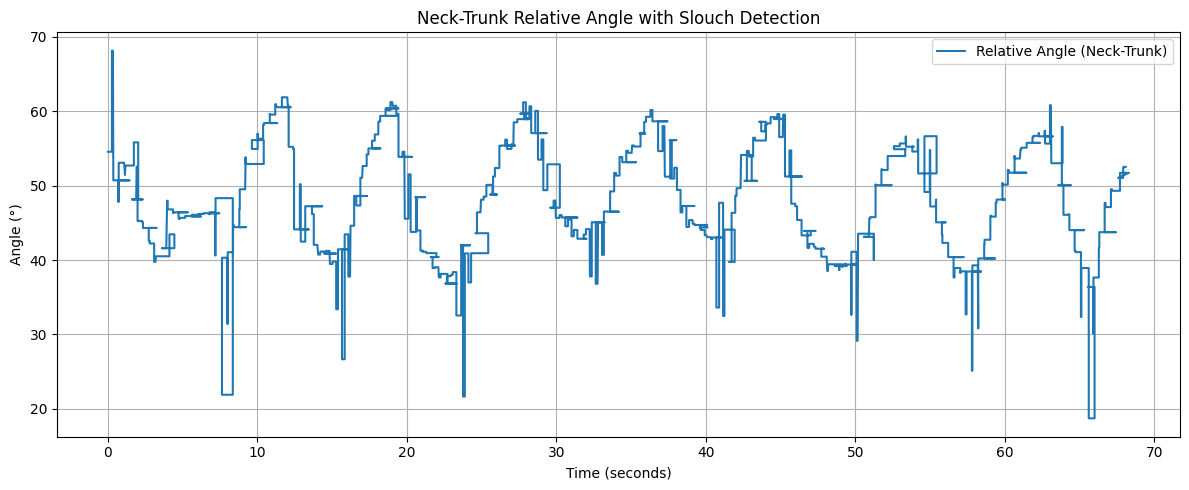

: 

In [ ]:
# === PLOT ===
%matplotlib inline
plt.figure(figsize=(12, 5))
plt.plot(result_df["Elapsed_sec"], result_df["Relative_Angle_deg"], label="Relative Angle (Neck-Trunk)")
#plt.axhline(threshold_deg, color='r', linestyle='--', label=f"Slouch Threshold = {threshold_deg}°")

# Optional shaded slouch periods
#for i in range(1, len(result_df)):
    #if result_df["Slouch_Flag"].iloc[i] == 1:
        #plt.axvspan(result_df["Elapsed_sec"].iloc[i-1], result_df["Elapsed_sec"].iloc[i], color='red', alpha=0.15)

plt.xlabel("Time (seconds)")
plt.ylabel("Angle (°)")
plt.title("Neck-Trunk Relative Angle with Slouch Detection")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Saved β (angle to Y-axis) for neck sensor to 'neck_with_beta.csv'.
Saved β (angle to Y-axis) for neck sensor to 'trunk_with_beta.csv'.


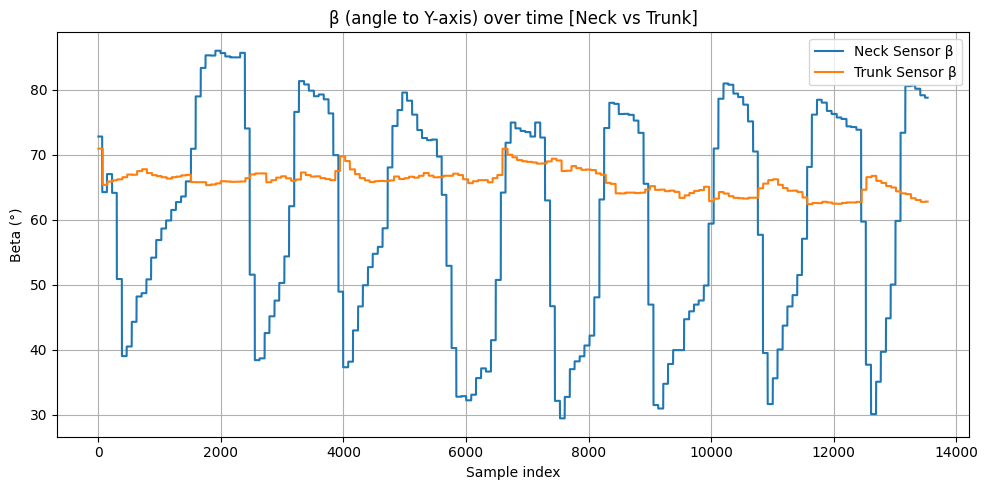

In [55]:
## BETA ANGLE OF EACH NECK AND TRUNK ##
# assums that y axis was put to the sky
# neck
# --- Extract quaternion components (from neck sensor only) ---
q0_n = neck_df["Q0()"].values
q1_n = neck_df["Q1()"].values
q2_n = neck_df["Q2()"].values
q3_n = neck_df["Q3()"].values

# --- Normalize quaternions ---
norm = np.sqrt(q0_n**2 + q1_n**2 + q2_n**2 + q3_n**2)
q0_n /= norm
q1_n /= norm
q2_n /= norm
q3_n /= norm

# --- Quaternion rotation function ---
def rotate_vector_by_quaternion(q0_n, q1_n, q2_n, q3_n, v=np.array([0, 1, 0])):
    R = np.array([
        [1 - 2*(q2_n**2 + q3_n**2),     2*(q1_n*q2_n - q0_n*q3_n),     2*(q1_n*q3_n + q0_n*q2_n)],
        [    2*(q1_n*q2_n + q0_n*q3_n), 1 - 2*(q1_n**2 + q3_n**2),     2*(q2_n*q3_n - q0_n*q1_n)],
        [    2*(q1_n*q3_n - q0_n*q2_n),     2*(q2_n*q3_n + q0_n*q1_n), 1 - 2*(q1_n**2 + q2_n**2)]
    ])
    return R @ v

# --- Compute β angle ---
beta_list_n = []
for i in range(len(neck_df)):
    q_n = [q0_n[i], q1_n[i], q2_n[i], q3_n[i]]
    u_n = rotate_vector_by_quaternion(*q_n)
    uy_n = u_n[1]  # y-component
    uy_n = np.clip(uy_n, -1.0, 1.0)
    beta_rad_n = math.acos(uy_n)
    beta_deg_n = math.degrees(beta_rad_n)
    beta_list_n.append(beta_deg_n)

# --- Add β to neck_df and save ---
neck_df["Beta (deg)"] = beta_list_n
neck_df.to_csv("neck_with_beta.csv", index=False)
print("Saved β (angle to Y-axis) for neck sensor to 'neck_with_beta.csv'.")


# trunk
# --- Extract quaternion components (from neck sensor only) ---
q0_t = trunk_df["Q0()"].values
q1_t = trunk_df["Q1()"].values
q2_t = trunk_df["Q2()"].values
q3_t = trunk_df["Q3()"].values

# --- Normalize quaternions ---
norm = np.sqrt(q0_t**2 + q1_t**2 + q2_t**2 + q3_t**2)
q0_t /= norm
q1_t /= norm
q2_t /= norm
q3_t /= norm

# --- Quaternion rotation function ---
def rotate_vector_by_quaternion(q0_t, q1_t, q2_t, q3_t, v=np.array([0, 1, 0])):
    R = np.array([
        [1 - 2*(q2_t**2 + q3_t**2),     2*(q1_t*q2_t - q0_t*q3_t),     2*(q1_t*q3_t + q0_t*q2_t)],
        [    2*(q1_t*q2_t + q0_t*q3_t), 1 - 2*(q1_t**2 + q3_t**2),     2*(q2_t*q3_t - q0_t*q1_t)],
        [    2*(q1_t*q3_t - q0_t*q2_t),     2*(q2_t*q3_t + q0_t*q1_t), 1 - 2*(q1_t**2 + q2_t**2)]
    ])
    return R @ v

# --- Compute β angle ---
beta_list_t = []
for i in range(len(neck_df)):
    q_t = [q0_t[i], q1_t[i], q2_t[i], q3_t[i]]
    u_t = rotate_vector_by_quaternion(*q_t)
    uy_t = u_t[1]  # y-component
    uy_t = np.clip(uy_t, -1.0, 1.0)
    beta_rad_t = math.acos(uy_t)
    beta_deg_t = math.degrees(beta_rad_t)
    beta_list_t.append(beta_deg_t)

# --- Add β to neck_df and save ---
trunk_df["Beta (deg)"] = beta_list_t
trunk_df.to_csv("neck_with_beta.csv", index=False)
print("Saved β (angle to Y-axis) for neck sensor to 'trunk_with_beta.csv'.")

# --- Combined β angle plot: Neck and Trunk ---
plt.figure(figsize=(10, 5))
plt.plot(beta_list_n, label="Neck Sensor β")
plt.plot(beta_list_t, label="Trunk Sensor β")
plt.title("β (angle to Y-axis) over time [Neck vs Trunk]")
plt.ylabel("Beta (°)")
plt.xlabel("Sample index")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()